In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy import sparse
from sklearn.decomposition import PCA, TruncatedSVD

# Load and Preprocess Data
Filter our users based on total play count and drop unnecessary columns.


In [252]:
filtered_df.groupby('user').count().shape

(6904, 3)

In [2]:
user_df = pd.read_csv("../data/filtered_user_df.csv")
user_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)


In [25]:
user_df.head()

,user,artist_name,play_count,artist_url
0,nyancrimew,Jasmine Thompson,7559.0,https://www.last.fm/music/Jasmine+Thompson
1,nyancrimew,Eminem,5851.0,https://www.last.fm/music/Eminem
2,nyancrimew,Watsky,3044.0,https://www.last.fm/music/Watsky
3,nyancrimew,Linkin Park,2938.0,https://www.last.fm/music/Linkin+Park
4,nyancrimew,twenty one pilots,1849.0,https://www.last.fm/music/twenty+one+pilots


In [4]:
# Getting total play counts for users and filtered some out 

user_total_play = (
    user_df.groupby("user")["play_count"]
    .sum()
    .reset_index(name="total_play_count")
)
filtered_users = user_total_play[
    user_total_play["total_play_count"] >= 50000
]["user"]
filtered_df = user_df[user_df["user"].isin(filtered_users)]
filtered_df['play_count'] = filtered_df['play_count'].map(lambda x: 1)

C:\Users\joshu\AppData\Local\Temp\ipykernel_16724\3519592273.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['play_count'] = filtered_df['play_count'].map(lambda x: 1)


In [5]:
filtered_df.head()

,user,artist_name,play_count,artist_url
138,angilbertomnz,Lady Gaga,1,https://www.last.fm/music/Lady+Gaga
139,angilbertomnz,Beyoncé,1,https://www.last.fm/music/Beyonc%C3%A9
140,angilbertomnz,Natasha Bedingfield,1,https://www.last.fm/music/Natasha+Bedingfield
141,angilbertomnz,Madonna,1,https://www.last.fm/music/Madonna
142,angilbertomnz,Christina Aguilera,1,https://www.last.fm/music/Christina+Aguilera


Convert this to a sparse matrix. Start by mapping users and artists to a unique numeric value.

In [6]:
user_ids = filtered_df["user"].unique()
artist_names = filtered_df["artist_name"].unique()

user_to_idx = {user: i for i, user in enumerate(user_ids)}
artist_to_idx = {artist: j for j, artist in enumerate(artist_names)}

# Convert rows to (row index, column index, value) tuples
rows = filtered_df["user"].map(user_to_idx)
cols = filtered_df["artist_name"].map(artist_to_idx)
values = filtered_df["play_count"]
sparse_matrix = sparse.coo_matrix(
    (values, (rows, cols)), shape=(len(user_ids), len(artist_names))
)


In [7]:
# View sparse matrix
dense_matrix = sparse_matrix.todense()

row, col, data = sparse.find(sparse_matrix)

for r, c, d in zip(row[:10], col[:10], data[:10]):
    print(f"User index: {r}, Artist index: {c}, Play count: {d}")


User index: 0, Artist index: 0, Play count: 1
User index: 2, Artist index: 0, Play count: 1
User index: 12, Artist index: 0, Play count: 1
User index: 16, Artist index: 0, Play count: 1
User index: 17, Artist index: 0, Play count: 1
User index: 20, Artist index: 0, Play count: 1
User index: 25, Artist index: 0, Play count: 1
User index: 33, Artist index: 0, Play count: 1
User index: 35, Artist index: 0, Play count: 1
User index: 42, Artist index: 0, Play count: 1


Load in the artist location data.

In [8]:
with open('../data/artist_location_codes.json', 'r') as file:
    artist_locations = json.load(file)
priveleged_locations = ['US', 'CA', 'GB']

# Collabroative Filtering
Use `TruncatedSVD`.

**Collaborative Filtering**: Assumption is that if users $A$ and $B$ rate items similarly, $A$ is more likely to have $B$'s opinion on an item (artist) than that of another randomly chosen user.

Use **SVD** to decompose the original sparse matrix (users' interactions with items, i.e., play counts) into lower-dimensional matrices, capturing latent factors with users and items.

In [9]:
num_components = 50  # Number of latent factors to represent users and items

# Matrix factorization with TruncatedSVD
svd = TruncatedSVD(n_components=num_components, random_state=42)

user_features = svd.fit_transform(
    sparse_matrix
)  # Represent the users in the reduced latent factor space.
item_features = svd.components_
user_ratings = np.dot(user_features, item_features)

## Visualize Artist Latent Features with PCA

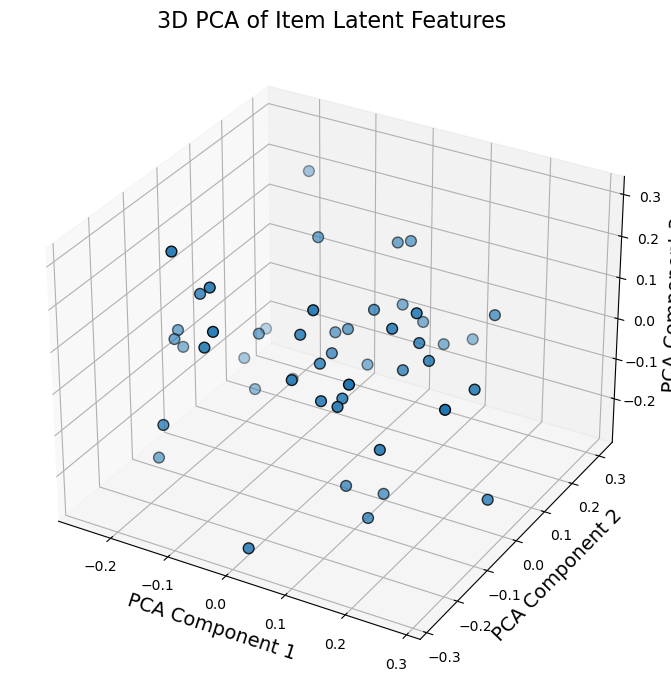

In [10]:
def visualize_latent_features(
    _item_features: np.ndarray, item_labels: list[int] = None
) -> None:
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(_item_features)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    if item_labels is not None:
        for i, label in enumerate(item_labels):
            ax.scatter(
                reduced_features[i, 0],
                reduced_features[i, 1],
                reduced_features[i, 2],
                label=label,
                edgecolor="k",
                s=60,
            )
        ax.legend(fontsize="small", loc="best")
    else:
        ax.scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            reduced_features[:, 2],
            edgecolor="k",
            s=60,
        )

    ax.set_xlabel("PCA Component 1", fontsize=14)
    ax.set_ylabel("PCA Component 2", fontsize=14)
    ax.set_zlabel("PCA Component 3", fontsize=14)
    ax.set_title("3D PCA of Item Latent Features", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_latent_features(item_features)


In [11]:
# idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


# def recommend_artists(
#     _user_id: int,
#     _user_features: np.ndarray,
#     _item_features: np.ndarray,
#     top_n: int = 5,
#     underrepresented_weight = 1
# ) -> list[str]:
#     # Convert 
#     # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
#     predicted_ratings = np.dot(_user_features, _item_features)
#     user_ratings = predicted_ratings[_user_id, :]
#     print(_item_features.shape)
#     # Calculate reweighting vector TODO: There has to be a less computationally intense way of calculating this
#     reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
#     reweighted_ratings = user_ratings * reweighting_vec
#     recommended_item_idx = np.argsort(reweighted_ratings)[::-1]
#     # This is horribly inefficient, optimize
#     recommended_artist_names = [
#         idx_to_artist[idx] for idx in recommended_item_idx
#     ]
#     username = idx_to_user[_user_id]
#     user_listened_artists = filtered_df[filtered_df['user'] == username]['artist_name']
#     for artist in user_listened_artists:
#         recommended_artist_names.remove(artist)
#     return recommended_artist_names[:top_n]


In [247]:
popularity_df = filtered_df.applymap(lambda x: artist_to_idx[x] if x in artist_to_idx else 0, na_action='ignore')
country_df = filtered_df.assign(country=filtered_df['artist_name'].map(artist_locations))
country_total_favorites = country_df.groupby('country')['user'].count()
popularity_rank = popularity_df.groupby('artist_name')['user'].count()
country_totals = popularity_rank.index.map(idx_to_artist).map(artist_locations).map(country_total_favorites)
# Solves the David Guetta/Bjork Problem as well as the Polish Drake problem

In [270]:
# For counting highest within country
country_counts = country_df.groupby('country')['artist_name'].transform('count')
artist_ranks = country_df.groupby(['country', 'artist_name']).rank(method='average')#.astype(int)

In [278]:
country_df.groupby(['country', 'artist_name']).count()['play_count'].rank()

country  artist_name     
AL       The Dreams           5269.0
AM       Aram MP3             5269.0
         Djivan Gasparyan     5269.0
AR       107 Faunos          12344.0
         2 Minutos           15081.5
                              ...   
ZA       Winter Soul          5269.0
         Yoav                18380.5
         Zenzile             15081.5
         jj                  21552.0
ZW       The Green Arrows     5269.0
Name: play_count, Length: 23925, dtype: float64

In [287]:
import pandas as pd

# Sample dataframe creation
# Assuming your dataframe has columns 'Artist', 'Country', and 'PlayCount'
data = {
    'Artist': ['Taylor Swift', 'Bjork', 'Artist A', 'Artist B', 'Artist C', 'Artist D'],
    'Country': ['USA', 'Iceland', 'USA', 'Iceland', 'USA', 'Iceland'],
    'PlayCount': [1000, 500, 800, 300, 600, 400]
}
df = pd.DataFrame(data)

# Group by 'Country', then sort within each group by 'PlayCount' in descending order
df_sorted = df.sort_values(['Country', 'PlayCount'], ascending=[True, False])

# Assign rank within each group
df_sorted['Rank'] = df_sorted.groupby('Country')['PlayCount'].rank("dense", ascending=False)

print(df_sorted)


         Artist  Country  PlayCount  Rank
1         Bjork  Iceland        500   1.0
5      Artist D  Iceland        400   2.0
3      Artist B  Iceland        300   3.0
0  Taylor Swift      USA       1000   1.0
2      Artist A      USA        800   2.0
4      Artist C      USA        600   3.0


In [317]:
country_artist_counts = country_df.groupby(['country', 'artist_name']).count().reset_index()
sorted_within_country = country_artist_counts.sort_values(['country', 'play_count'], ascending=[True, False])
sorted_within_country['rank'] = sorted_within_country.groupby('country')['play_count'].rank("dense", ascending=False)
country_favorite_counts = sorted_within_country.groupby('country').count()['play_count']
sorted_within_country['country_total'] = sorted_within_country['country'].map(country_favorite_counts)
sorted_within_country['artist_idx'] = sorted_within_country['artist_name'].map(artist_to_idx)
sorted_within_country = sorted_within_country.set_index('artist_idx')
artist_rank_proportions = sorted_within_country['rank'] / sorted_within_country['country_total'] # TODO: Add metric for play count proportions

In [211]:
idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


def recommend_artists(
    _user_liked_artists: list,
    _item_features: np.ndarray,
    top_n: int = 5,
    underrepresented_weight = 1,
    popularity_weight = 0
) -> list[str]:
    # Convert liked artists to user features
    user_info_array = np.array([[int(artist in _user_liked_artists) for artist in artist_names]])
    user_features = svd.transform(user_info_array)
    # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
    user_ratings = np.dot(user_features, _item_features)
    # Calculate reweighting vector TODO: There has to be a less computationally intense way of calculating this
    reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
    popularity_weighting_vec = ((1 - popularity_rank / country_totals) ** popularity_weight).array
    reweighted_ratings = user_ratings * reweighting_vec * popularity_weighting_vec + (user_info_array * -1000) # Filter out artists user already likes
    recommended_item_idx = np.argsort(reweighted_ratings[0])[::-1]
    # match = user_ratings[0][recommended_item_idx[:top_n]].sum() / len(_user_liked_artists) # THIS IS NOT CORRECT
    # This is horribly inefficient, optimize
    recommended_artist_names = [
        idx_to_artist[idx] for idx in recommended_item_idx
    ]
    return recommended_artist_names[:top_n]


In [242]:
# Example
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

def get_user_liked_artists(user_id):
    # Returns a list of names of artists the user likes
    liked_artists = filtered_df[filtered_df['user'] == filtered_df['user'].unique()[user_id]]['artist_name'].array
    return liked_artists

def recommend_for_user(user_id: int, top_n: int, underrepresented_weight = 1, popularity_weight = float('inf')) -> None:
    recommended_artists = recommend_artists(
        get_user_liked_artists(user_id), item_features, top_n, underrepresented_weight, popularity_weight
    )
    username = idx_to_user[user_id]
    print(f"Recommended artists for user {username}: {recommended_artists}")


recommend_for_user(4000, 10, 100, 400)

# TODO: Solve the David Guetta Problem
# TODO: Solve the B.o.B problem
# J-Pop problem

Recommended artists for user GabrielHitz: ['TOPS', 'Pond', 'Captain Murphy', 'Don L', 'Lucky Twice', "Melody's Echo Chamber", 'Black Drawing Chalks', 'Lô Borges', 'Temples', 'Lamp']


In [319]:
my_liked_artists = ['Bladee', 'Everything Everything', 'Aesop Rock', 'Danny Brown', 'cLOUDDEAD', 'Kanye West', 'Kid Cudi', 'Sigur Rós', 'The 1975', 'At the Drive-In', 'The Avalanches', 
                   'Dance Gavin Dance', 'The Dillinger Escape Plan', 'Lil B', 'LCD Soundsystem']
recommended_artists = recommend_artists(
    my_liked_artists, item_features, 10, 100, 400
)
recommended_artists

['Fishmans',
 'Ludwig Göransson',
 'Captain Murphy',
 'Lucky Twice',
 'A Winged Victory for the Sullen',
 'Gallows',
 'Julia Brown',
 'The Throne',
 'Clark',
 'Mono']

In [15]:
# avg_match is the average of the match scores given by the model to the artists it recommends. We want to maximize this
# underrepresented_proportion is the percentage of recommended artists that are from underrepresented countries. We want to maximize this
def calc_metrics(top_n = 10, underrepresented_weight = 1, popularity_weight = 0):
    num_users = user_features.shape[0]
    underrepresented_count = 0
    total_artist_count = 0
    total_match = 0
    mean_popularity_rank = 0
    avg_highest_rank_rec = 0
    popularity_weighting_vec = ((1 - popularity_rank / country_totals) ** popularity_weight).array
    
    for i in range(num_users):
        # if i % 100 == 0:
        #     print(i)

        user_liked_artists = get_user_liked_artists(i)
        rating_row = user_ratings[i]
        user_artist_idxs = [artist_to_idx[artist] for artist in user_liked_artists]
        reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
        reweighted_ratings = rating_row * reweighting_vec * popularity_weighting_vec + (user_info_array * -1000)
        
        recommended_item_idx = np.argsort(reweighted_ratings)[::-1]
        match = user_ratings[i][recommended_item_idx[:top_n]].sum() / len(user_liked_artists)
        total_match += match
        
        underrepresented_artists = [artist_locations[idx_to_artist[idx]] not in priveleged_locations for idx in recommended_item_idx[:top_n]]
        underrepresented_count += sum(underrepresented_artists)
        # Artist Popularity Bias (APB)
        mean_popularity_rank += popularity_rank[recommended_item_idx[:top_n]].sum()
        total_artist_count += len(underrepresented_artists)
        
        # Highest rank recommendation
        highest_rank_rec = artist_rank_proportions[recommended_item_idx[:top_n]].max()
        avg_highest_rank_rec += highest_rank_rec
        

    avg_match = total_match / num_users
    underrepresented_proportion = underrepresented_count / total_artist_count
    mean_popularity_rank /= total_artist_count
    avg_highest_rank_rec /= num_users
    return avg_match, underrepresented_proportion, mean_popularity_rank, avg_highest_rank_rec

In [18]:
# Grid search over the metrics
# search_results = {}
for underrepresented_weight in [1, 2, 3, 5, 10, 20]:
    for popularity_weight in [0, 1, 10, 50, 100, 200, 40]:
        # if popularit
        # search_results[(underrepresented_weight, popularity_weight)] = calc_metrics(10, underrepresented_weight, popularity_weight)
        print(f'Logged {underrepresented_weight, popularity_weight}: {search_results[(underrepresented_weight, popularity_weight)]}')

Logged (1, 0): (0.14762643255245825, 0.19207705677867903, 626.7923667439165)
Logged (1, 1): (0.13449544680647482, 0.2213933951332561, 465.5688876013905)
Logged (1, 2): (0.11715364314014294, 0.23623986095017382, 356.58174971031286)
Logged (1, 3): (0.10269156086233772, 0.24130938586326767, 287.03467555040555)
Logged (1, 5): (0.0804594154086227, 0.2458864426419467, 201.8237108922364)
Logged (1, 7): (0.06725801733450641, 0.25751738122827345, 158.10447566628042)
Logged (2, 0): (0.1406646478927359, 0.41135573580533025, 589.0963933951333)
Logged (2, 1): (0.12166603122906657, 0.512239281575898, 422.4100811123986)
Logged (2, 2): (0.1041272424685082, 0.5743482039397451, 326.34687137891075)
Logged (2, 3): (0.09099352178857258, 0.6223493626882967, 266.29481460023175)
Logged (2, 5): (0.06930626330732588, 0.6855880648899189, 184.08253186558517)
Logged (2, 7): (0.057032344474730434, 0.7273899188876014, 142.51557068366165)
Logged (3, 0): (0.1284625321862227, 0.5719293163383545, 543.4181488991889)
Logg

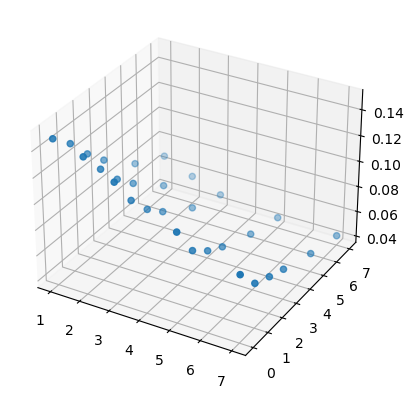

In [39]:
# Match
ax = plt.axes(projection='3d')
ax.scatter3D(list(map(lambda x: x[0], search_results.keys())), list(map(lambda x: x[1], search_results.keys())), list(map(lambda x: x[0], search_results.values())))

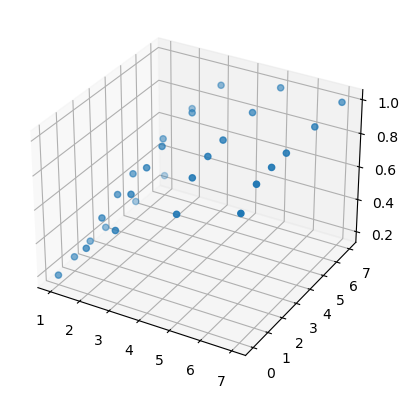

In [41]:
# Diversity
ax = plt.axes(projection='3d')
ax.scatter3D(list(map(lambda x: x[0], search_results.keys())), list(map(lambda x: x[1], search_results.keys())), list(map(lambda x: x[1], search_results.values())))

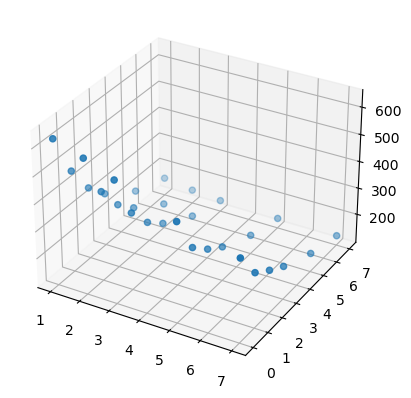

In [42]:
# Popularity
ax = plt.axes(projection='3d')
ax.scatter3D(list(map(lambda x: x[0], search_results.keys())), list(map(lambda x: x[1], search_results.keys())), list(map(lambda x: x[2], search_results.values())))